In [3]:
from uav_routing.environment.data import load
from uav_routing.environment.plot import plot_graph_with_positions
from uav_routing.initial_tour import (tour_with_nearest_neighbors,
                                      tour_with_max_ratio,
                                      random_tour,
                                      random_then_nn_tour)
import pandas as pd

path = '/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/results_k3_detailed.csv'
df = pd.read_csv(path)
callibrated_path ="/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/calibrated_env.pkl"
data = load(callibrated_path)

graph, drone = data['graph'], data['drone']

t1 = tour_with_nearest_neighbors(graph, drone, df, length=3)
t2 = tour_with_max_ratio(graph, drone, df, length=3)
t3 = random_tour(df)
t4 = random_then_nn_tour(graph, drone, df, length=3)

Feasible NN Tour Found: 0-20-21
Objective: 91.41 | Distance: 22198.04


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

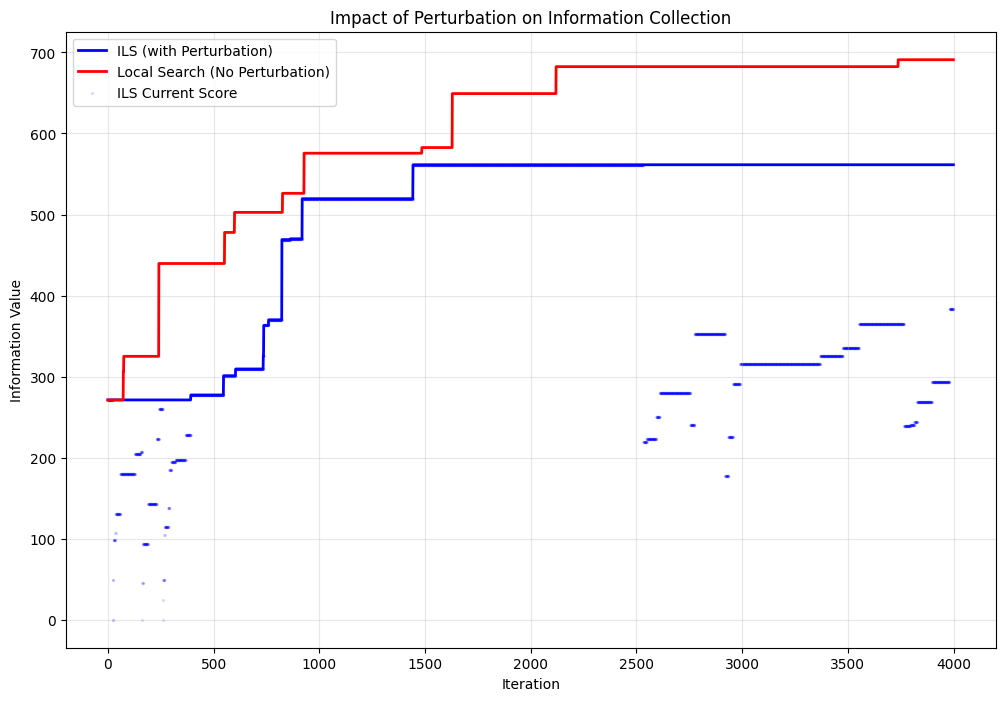

In [4]:
from functools import partial
from uav_routing.environment.graph import directed_cycle
from uav_routing.state import State
from uav_routing.iterator import Iterator
from uav_routing.accept import always_accept
from uav_routing.optimization import Optimizer
from uav_routing.proposal import universal_proposal, random_flip_with_tabu
import matplotlib.pyplot as plt
import numpy as np
from functools import partial


tour = directed_cycle(t2, graph)
initial_state = State.initial_state(graph, drone, tour, None)

proposal_func = partial(random_flip_with_tabu)

proposal_func_2 = lambda s: universal_proposal(None, s)

iteration = Iterator(
    proposal=proposal_func,
    accept=always_accept,
    initial_state=initial_state,
    total_steps=4000,
)

optimizer = Optimizer(
    proposal=proposal_func,
    initial_state=initial_state,
    maximize=True,
)

total_steps = 4000

# ----- 1. ILS WITH Perturbation (The "Shake")
#optimizer.reset_to_initial() # Ensure we start from the original state
max_scores_ILS = np.zeros(total_steps)
curr_scores_ILS = np.zeros(total_steps)

for i, state in enumerate(optimizer.run_ils(
    total_steps=total_steps, 
    t_improve=10,      # Shakes after 50 steps of no improvement
    k_remove=5, 
    tabu_tenure=10, 
    with_progress_bar=True
)):
    max_scores_ILS[i] = optimizer.best_score
    curr_scores_ILS[i] = state.value



# ----- 2. ILS WITHOUT Perturbation (Standard Local Search)
optimizer_2 = Optimizer(
    proposal=proposal_func_2,
    initial_state=initial_state,
    maximize=True,
)
max_scores_NoShake = np.zeros(total_steps)
curr_scores_NoShake = np.zeros(total_steps)

# We set t_improve > total_steps so it never perturbs
for i_2, state_2 in enumerate(optimizer_2.run_ils(
    total_steps=total_steps, 
    t_improve=total_steps + 1, 
    with_progress_bar=True
)):
    max_scores_NoShake[i_2] = optimizer_2.best_score
    curr_scores_NoShake[i_2] = state_2.value

# ----- plotting
plt.figure(figsize=(12, 8))

# Plot the "Best Found So Far" (The monotonic curves)
plt.plot(max_scores_ILS, label='ILS (with Perturbation)', color='blue', linewidth=2)
plt.plot(max_scores_NoShake, label='Local Search (No Perturbation)', color='red', linewidth=2)

# Plot the actual state values to see the "Shakes"
# You will see the blue dots "jump" down when a shake happens, then climb back up
plt.scatter(range(total_steps), curr_scores_ILS, s=2, color='blue', alpha=0.1, label='ILS Current Score')

plt.title('Impact of Perturbation on Information Collection')
plt.xlabel('Iteration')
plt.ylabel('Information Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

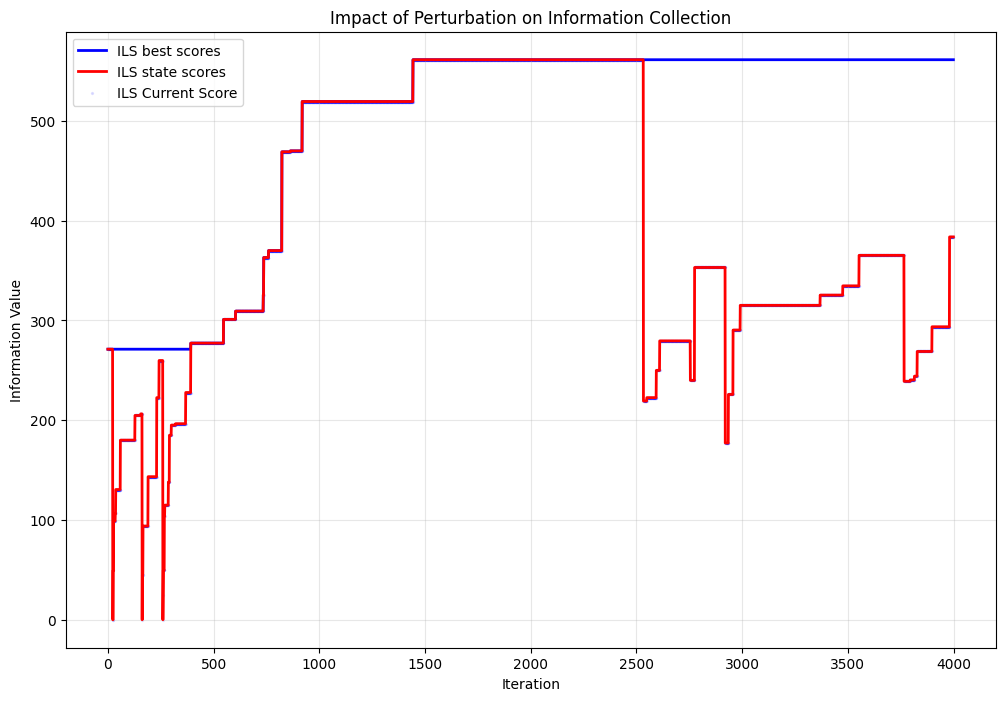

In [5]:

plt.figure(figsize=(12, 8))

# Plot the "Best Found So Far" (The monotonic curves)
plt.plot(max_scores_ILS, label='ILS best scores', color='blue', linewidth=2)
plt.plot(curr_scores_ILS, label='ILS state scores', color='red', linewidth=2)

# Plot the actual state values to see the "Shakes"
# You will see the blue dots "jump" down when a shake happens, then climb back up
plt.scatter(range(total_steps), curr_scores_ILS, s=2, color='blue', alpha=0.1, label='ILS Current Score')

plt.title('Impact of Perturbation on Information Collection')
plt.xlabel('Iteration')
plt.ylabel('Information Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

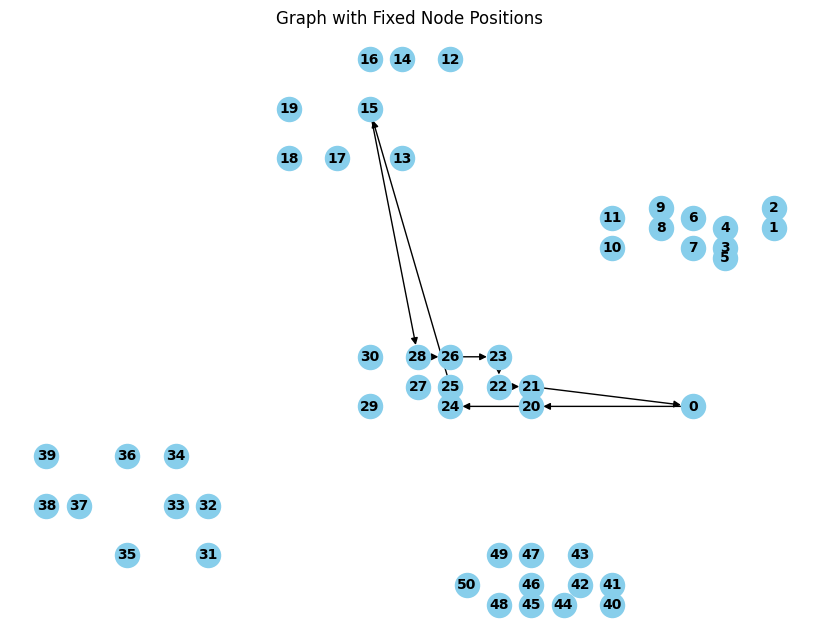

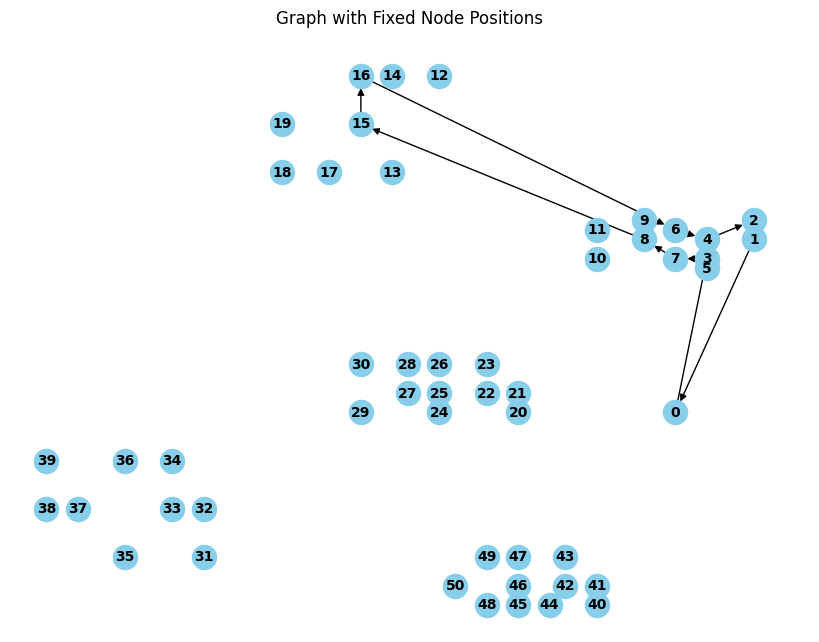

In [6]:
best_ILS = optimizer.best_state
best_no_ILS = optimizer_2.best_state
best_tour_ILS = best_ILS.tour
best_tour_no_ILS = best_no_ILS.tour
plot_graph_with_positions(graph.nodes, best_tour_ILS.edges)
plot_graph_with_positions(graph.nodes, best_tour_no_ILS.edges)

In [7]:
from tabulate import tabulate
from dataclasses import asdict

best_results_ILS = best_ILS.solver.get_tour_data()
data_dict_ILS = asdict(best_results_ILS)
table_ILS = data_dict_ILS.items()
print(tabulate(table_ILS))

best_results_no_ILS = best_no_ILS.solver.get_tour_data()
data_dict_no_ILS = asdict(best_results_no_ILS)
table_no_ILS = data_dict_no_ILS.items()
print(tabulate(table_no_ILS))

-------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sequence       [0, 20, 24, 25, 15, 28, 26, 23, 22, 21]
feasible       True
objective      561.4153317475634
total_energy   47875065.19802281
arrival_times  {0: 2582.3411346719868, 20: 180.6458459678206, 24: 356.34251248395316, 25: 418.2075832259179, 15: 1054.6620111898915, 28: 1467.4383955462035, 26: 1734.6952875054171, 23: 1922.7649622859767, 22: 2009.3760378312277, 21: 2261.7853480642866}
lengths        {(0, 20): 10134.98538245982, (20, 24): 6001.119263771823, (24, 25): 2540.7353268275465, (25, 15): 28667.534926533215, (15, 28): 25179.357983047976, (28, 26): 8004.734101237541, (26, 23): 5947.700618309622, (23, 22): 3523.3445541608276, (22, 21): 7622.36570961154, (21, 0): 10932.23

In [11]:
a = [0, 13, 5, 3, 20, 43, 32, 42, 24, 17, 33, 18, 7, 25, 41, 31, 27, 40, 8, 19, 35, 10, 44, 15, 29, 37, 11, 16, 30, 46, 38, 45, 9, 28, 39, 14, 26, 6, 36, 48, 12, 23, 34, 4, 2, 50, 22, 21, 1, 49, 47]
len(a)

51

In [8]:
import pandas as pd
from tabulate import tabulate

def analyze_final_tour(best_state, drone):
    # 1. Extract results from the solver inside the state
    tour_result = best_state.solver.get_tour_data()
    graph = best_state.graph
    
    if not tour_result.feasible:
        print("Final tour is not feasible. No analysis available.")
        return

    tour_data = []
    total_t, total_l, total_e = 0, 0, 0
    
    # sequence comes from TourResult (e.g., [0, 5, 3, 0])
    seq = tour_result.sequence
    # Add the base at the end to close the cycle loop for analysis
    full_seq = seq + [seq[0]] 

    for idx in range(len(full_seq) - 1):
        i, j = full_seq[idx], full_seq[idx+1]
        edge = (i, j)
        
        # Pull values from the dataclass dictionaries
        t_ij = tour_result.times[edge]
        L_ij = tour_result.lengths[edge]
        energy_ij = tour_result.energies[edge]
        
        # Real Euclidean distance (d_ij) from the graph
        d_ij = graph.edges[edge]['distance']
        
        # Calculated Speed and Loiter
        v_ij = L_ij / t_ij if t_ij > 0 else 0
        # Loitering happens if L_ij > d_ij or if speed is reduced
        loiter_time = max(0, t_ij - (d_ij / v_ij)) if v_ij > 0 else 0
        energy_pct = (energy_ij / drone.max_energy) * 100
        
        # Node specific info (target node j)
        node_j = graph.nodes[j]
        tw = node_j['time_window']
        arrival_j = tour_result.arrival_times.get(j, 0.0)
        
        # Calculate Information Collected at node j
        # Info = slope * (arrival - earliest) + info_at_earliest
        collected = node_j['info_slope'] * (arrival_j - tw[0]) + node_j['info_at_lowest']

        tour_data.append({
            "Edge": f"{i}->{j}",
            "Total Time (s)": round(t_ij, 2),
            "Loiter Time (s)": round(loiter_time, 2),
            "Speed (m/s)": round(v_ij, 2),
            "Energy (J)": round(energy_ij, 2),
            "Energy %": round(energy_pct, 4),
            "Arrival (s)": round(arrival_j, 2),
            "Window": f"[{tw[0]}, {tw[1]}]",
            "Info Collected": round(collected, 2)
        })

        total_t += t_ij
        total_l += loiter_time
        total_e += energy_ij

    # 2. Create DataFrame
    df = pd.DataFrame(tour_data)
    
    # 3. Print Report
    print("\n" + "="*30 + " FINAL ILS TOUR REPORT " + "="*30)
    print(tabulate(df, headers="keys", tablefmt="presto", showindex=False))
    print("-" * 83)
    print(f"FINAL OBJECTIVE (Total Info): {tour_result.objective:.2f}")
    print(f"TOTAL ENERGY CONSUMPTION:     {total_e:.2f} J ({(total_e/drone.max_energy)*100:.2f}%)")
    print(f"TOTAL TOUR DURATION:          {total_t:.2f} seconds")
    print(f"FULL SEQUENCE:                {' -> '.join(map(str, seq))} -> {seq[0]}")
    print("="*83)

# Usage:
analyze_final_tour(best_state_ILS, drone)


============================== FINAL ILS TOUR REPORT ==============================
 Edge   |   Total Time (s) |   Loiter Time (s) |   Speed (m/s) |   Energy (J) |   Energy % |   Arrival (s) | Window                                   |   Info Collected
--------+------------------+-------------------+---------------+--------------+------------+---------------+------------------------------------------+------------------
 0->32  |          1805.83 |            600.73 |         26.24 |  3.10128e+07 |     2.6268 |       1805.83 | [1805.8252427184466, 5825.242718446602]  |          1747.57
 32->5  |           665.71 |              0    |         61    |  2.36921e+07 |     2.0067 |       2471.53 | [873.7864077669904, 3902.9126213592235]  |           326.74
 5->3   |          1314.88 |           1276.86 |         26.3  |  2.39929e+07 |     2.0322 |       3786.41 | [3786.4077669902913, 8504.85436893204]   |           582.52
 3->20  |           327.87 |              0    |         61    |  1.5

# Neden base de beklemesine izin vermiyoruz?

The drone must wait at the start to hit a late window later without burning energy loitering in the air.

Allow the first var_arrival to be $\ge$ the travel time from base

In [ ]:
#----- Simulated Annealing
# We pass the universal_proposal so SA knows HOW to move
max_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, state in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(20, 80),
        proposal=optimizer.universal_proposal, # <--- CONNECTED HERE
        with_progress_bar=True
    )):
    max_scores_anneal[i] = optimizer.best_score
    scores_anneal[i] = optimizer.score(state)
best_state_anneal = optimizer.best_state


#----- Ascent
max_scores_as = np.zeros(total_steps)
scores_as = np.zeros(total_steps)
for i, part in enumerate(
    optimizer.ascent_run(
        total_steps, 
        proposal=optimizer.universal_proposal, 
        with_progress_bar=True
    )):
    max_scores_as[i] = optimizer.best_score
    scores_as[i] = optimizer.score(part)
best_state_as = optimizer.best_state


#----- Short Bursts
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(num_bursts=5, burst_length=200, proposal=optimizer.universal_proposal, with_progress_bar=True)):
    max_scores_sb[i] = optimizer.best_score
    scores_sb[i] = optimizer.score(part)
best_state_sb = optimizer.best_state

# ----- Tilted Run
max_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, proposal=optimizer.universal_proposal, with_progress_bar=True)):
    max_scores_tilt[i] = optimizer.best_score
    scores_tilt[i] = optimizer.score(part)
best_state_tilt = optimizer.best_state

In [ ]:
plt.figure(figsize=(12, 8))

# Plot the "Best Found" curves
plt.plot(max_scores_as, label='Ascent (Greedy)', alpha=0.8)
plt.plot(max_scores_anneal, label='Simulated Annealing', linewidth=2)
plt.plot(max_scores_sb, label='Short Bursts', linestyle='--')
plt.plot(max_scores_ILS, label='Iterative Local Search', color='black', linewidth=2.5)

# Optional: Plot the actual 'noisy' scores for ILS to show the Shakes
plt.scatter(range(total_steps), scores_ILS, s=1, color='gray', alpha=0.3, label='ILS Exploration')

plt.title('UAV Information Collection: Metaheuristic Comparison')
plt.xlabel('Iteration')
plt.ylabel('Information Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('optimization_comparison.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(scores_as, label="Ascent Run")
plt.plot(scores_sb, label="Short Bursts")
plt.plot(scores_anneal, label="Simulated Annealing")
plt.plot(scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Total Collected Info", fontsize=20)
plt.legend(fontsize=9)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_as, label="Ascent")
plt.plot(max_scores_sb, label="Short Busts")
plt.plot(max_scores_tilt, label="Tilted Run")

plt.xlabel("Steps", fontsize=20)
plt.ylabel("Total Collected Info", fontsize=20)
plt.legend(fontsize=9)
plt.show()

In [ ]:
print("Best Objective Values")
print("Annealing", max(max_scores_anneal))
print("Ascent", max(max_scores_as))
print("Shorts Busts", max(max_scores_sb))
print("Tilted", max(max_scores_tilt))

In [ ]:
from uav_routing.environment.plot import plot_graph_with_positions
import networkx as nx
plot_graph_with_positions(state.nodes, list(state.tour.edges))

In [ ]:
plot_graph_with_positions(nodes, list(T.edges))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from uav_routing.optimization import Optimizer
from uav_routing.state import State
from uav_routing.environment.graph import directed_cycle

def run_strategy_comparison(graph, drone, df, total_steps=2000):
    # These functions currently return a pandas Series based on your output
    
    
    results = {}
    proposal_func = lambda s: universal_proposal(None, s)

    for name, series_data in strategies_raw.items():
        # 1. Extract the sequence string "0-20-21"
        raw_seq = series_data['sequence']
        
        # 2. Convert "0-20-21" into [0, 20, 21]
        if isinstance(raw_seq, str):
            clean_tour = [int(node) for node in raw_seq.split('-')]
        else:
            clean_tour = list(raw_seq)

        print(f"Running ILS for {name} with sequence: {clean_tour}")
        
        # 3. Build the directed cycle
        tour = directed_cycle(clean_tour, graph)
        
        # Proceed with Optimizer...
        initial_state = State.initial_state(graph, drone, tour, None)
        optimizer = Optimizer(
            proposal=proposal_func,
            initial_state=initial_state,
            maximize=True,
        )

        
        # Trackers
        max_scores = np.zeros(total_steps)
        current_scores = np.zeros(total_steps)
        
        # Run ILS
        for i, state in enumerate(optimizer.run_ils(
            total_steps=total_steps, 
            t_improve=50, 
            k_remove=3, 
            tabu_tenure=20, 
            with_progress_bar=True
        )):
            max_scores[i] = optimizer.best_score
            current_scores[i] = optimizer.score(state)
            
        results[name] = {
            "max_history": max_scores,
            "current_history": current_scores,
            "best_state": optimizer.best_state
        }
        
    return results

# Execute the experiment
all_results = run_strategy_comparison(graph, drone, df, total_steps=2000)

def plot_results(results, total_steps):
    plt.figure(figsize=(14, 8))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, (name, data) in enumerate(results.items()):
        # Plot the Best Found (Staircase)
        plt.plot(data["max_history"], label=f'{name} (Best)', color=colors[i], linewidth=2.5)
        
        # Optional: Plot the exploration cloud for just one strategy to keep it clean
        if i == 0: # Showing exploration dots only for the first one for clarity
            plt.scatter(range(total_steps), data["current_history"], 
                        s=1, color=colors[i], alpha=0.1, label=f'{name} Probes')

    plt.title('Metaheuristic Convergence: Comparing Initial Tour Strategies (ILS)', fontsize=14)
    plt.xlabel('Iteration')
    plt.ylabel('Information Value (Objective)')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_results(all_results, total_steps=2000)

Feasible NN Tour Found: 0-20-21
Objective: 2940.40 | Distance: 22198.04
Running ILS for T1: Nearest Neighbor with sequence: [0, 20, 21]


  0%|          | 0/2000 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not str

In [19]:
strategies_raw = {
        "T1: Nearest Neighbor": tour_with_nearest_neighbors(graph, drone, df, length=3),
        "T2: Max Ratio (Consump.)": tour_with_max_ratio(graph, drone, df, length=3),
        "T3: Random Feasible": random_tour(df),
        "T4: Random-Start Greedy": random_then_nn_tour(graph, drone, df, length=3)
    }
for name, series_data in strategies_raw.items():
    # 1. Extract the sequence string "0-20-21"
    raw_seq = series_data['sequence']
print(raw_seq)

Feasible NN Tour Found: 0-20-21
Objective: 2940.40 | Distance: 22198.04


TypeError: list indices must be integers or slices, not str

In [ ]:
for name, data in all_results.items():
    best_s = data["best_state"]

In [20]:
t1

sequence                                                    0-20-21
feasible                                                       True
objective                                               2940.401605
total_energy                                        1164497093.5833
total_dist                                             22198.039027
failure_reason                                                  NaN
arrival_times     {0: 62111.38764897037, 20: 4252.425837605816, ...
Name: 950, dtype: object

In [21]:
t2

[0, 33, 25]

In [22]:
t3

sequence                                                    0-27-29
feasible                                                       True
objective                                               1621.957206
total_energy                                      1166720213.893815
total_dist                                             40722.794044
failure_reason                                                  NaN
arrival_times     {0: 29766.880188425417, 27: 15203.88369668915,...
Name: 1301, dtype: object

In [23]:
t4

sequence                                                    0-29-30
feasible                                                       True
objective                                               1812.290771
total_energy                                       1163748617.20852
total_dist                                             45615.528128
failure_reason                                                  NaN
arrival_times     {0: 36707.18539549975, 29: 23592.232930438175,...
Name: 1400, dtype: object